# Cinemática directa y control de robot SCARA RRP

**Materia:** Robótica / Cinemática de Robots  
**Proyecto:** Implementación de cinemática directa y control de un SCARA RRP  
**Autores:** Kevyn David Delgado Gómez, Eduardo Montiel Salazar 

En este Notebook se implementa la cinemática directa de un robot SCARA RRP, 
se envían las variables articulares a un Arduino mediante puerto serial 
y se genera un GIF de evidencia con las pruebas realizadas.

El desarrollo cumple con los siguientes puntos del reporte:

- Cálculo de la cinemática directa a partir de (q1, q2, d3).
- Entrada manual de variables articulares.
- Envío de datos al Arduino a través del puerto serial.
- Registro de pruebas experimentales en una tabla.
- Generación de un GIF de evidencia con la ejecución del Notebook.


## 1. Importación de librerías y parámetros del robot

En esta sección se importan las librerías necesarias y se cargan los 
parámetros geométricos del robot SCARA desde el módulo `scara_kinematics`.


In [3]:
# ==========================================
# 1. IMPORTACIÓN DE LIBRERÍAS PRINCIPALES
# ==========================================
import numpy as np              # Cálculos numéricos (vectores, trigonometría, etc.)
import pandas as pd             # Manejo de tablas para registrar las pruebas
import serial                   # Comunicación serial con el Arduino
import time                     # Pausas y sincronización
import matplotlib.pyplot as plt # Gráficas y visualización

from IPython.display import HTML, display  # Para mostrar resultados "bonitos" en el Notebook

# Importar la cinemática desde el módulo del robot
from scara_kinematics import (
    fk_scara,          # FK completa (usa matrices DH y devuelve x, y, z, A1, A2, A3, T)
    fk_scara_planar,   # FK simplificada solo en el plano XY
    check_joint_limits,# Verificación de límites articulares
    L1, L2, D0         # Parámetros geométricos del SCARA (longitudes y altura)
)

# Mostrar gráficas incrustadas en el Notebook
%matplotlib inline

print("Librerías importadas y parámetros del robot cargados correctamente.")
print(f"L1 = {L1:.3f} m, L2 = {L2:.3f} m, D0 = {D0:.3f} m")


Librerías importadas y parámetros del robot cargados correctamente.
L1 = 0.100 m, L2 = 0.150 m, D0 = 0.012 m


## 2. Configuración de la comunicación serial con Arduino

En esta sección se configura el puerto serial que permite enviar las 
variables articulares `(q1, q2, d3)` desde el Notebook hacia el Arduino.


In [13]:
# ==========================================
# 2. CONFIGURACIÓN DEL PUERTO SERIAL
# ==========================================

# Nombre del puerto serial donde está conectado el Arduino.
# En Windows suele ser COMx; en Linux/Mac podría ser /dev/ttyUSB0 o similar.
SERIAL_PORT = "COM14"

# Velocidad de comunicación (debe coincidir con Serial.begin(...) en Arduino)
BAUD_RATE = 115200

# Objeto de puerto serial (se inicializa más abajo)
ser = None

try:
    # Intentar abrir el puerto serial
    ser = serial.Serial(SERIAL_PORT, BAUD_RATE, timeout=1)
    time.sleep(2)  # Pequeña pausa para que el Arduino termine de resetearse
    print(f"Puerto serial {SERIAL_PORT} abierto correctamente a {BAUD_RATE} baudios.")
except Exception as e:
    # Si no se puede abrir, se muestra la advertencia; el Notebook puede seguir
    print(f"Advertencia: no se pudo abrir el puerto {SERIAL_PORT}: {e}")
    print("Puedes continuar con la cinemática directa, pero no se enviarán datos al Arduino.")


Puerto serial COM14 abierto correctamente a 115200 baudios.


## 3. Prueba individual: entrada manual de (q1, q2, d3), FK y envío al Arduino

En esta sección el usuario introduce manualmente un conjunto de variables 
articulares. El Notebook:

1. Convierte los valores a radianes y metros.
2. Verifica si están dentro de los límites del robot.
3. Calcula la cinemática directa `(x, y, z)` usando `fk_scara`.
4. Muestra los resultados en pantalla.
5. Envía las variables al Arduino en el formato acordado.


In [6]:
# ==========================================
# 3. PRUEBA INDIVIDUAL DE CINEMÁTICA DIRECTA
# ==========================================

print("=== Prueba cinemática directa + envío a Arduino (un solo caso) ===")

# 1) Entrada de variables articulares en grados y milímetros
q1_deg = float(input("Ingresa q1 en grados: "))
q2_deg = float(input("Ingresa q2 en grados: "))
d3_mm  = float(input("Ingresa d3 en milímetros: "))

# 2) Conversión a radianes (para q1, q2) y metros (para d3)
q1_rad = np.deg2rad(q1_deg)
q2_rad = np.deg2rad(q2_deg)
d3_m   = d3_mm / 1000.0

# 3) Verificar límites articulares usando la función del módulo `scara_kinematics`
if not check_joint_limits(q1_rad, q2_rad, d3_m):
    print("\n[ADVERTENCIA] La configuración está fuera de los límites del robot.")
    print("Revisa los rangos válidos para q1, q2 y d3 antes de ejecutar en el robot físico.")
else:
    print("\nConfiguración dentro de los límites del robot.")

# 4) Calcular cinemática directa completa (usa matrices DH)
res = fk_scara(q1_rad, q2_rad, d3_m)
x, y, z = res["x"], res["y"], res["z"]

print("\n--- Resultados de la cinemática directa (FK) ---")
print(f"q1 = {q1_deg:.2f}°   q2 = {q2_deg:.2f}°   d3 = {d3_mm:.2f} mm")
print(f"x  = {x:.4f} m   y = {y:.4f} m   z = {z:.4f} m")

# 5) Enviar las variables al Arduino usando el formato acordado
if ser is not None:
    # Formato: q1_rad,q2_rad,d3_m\n
    line = f"{q1_rad:.4f},{q2_rad:.4f},{d3_m:.4f}\n"
    ser.write(line.encode("ascii"))
    print("\n[TX] Enviado al Arduino:", line.strip())
else:
    print("\n[INFO] No se envían datos al Arduino porque el puerto serial no está abierto.")


=== Prueba cinemática directa + envío a Arduino (un solo caso) ===


Ingresa q1 en grados:  -30
Ingresa q2 en grados:  -30
Ingresa d3 en milímetros:  20



Configuración dentro de los límites del robot.

--- Resultados de la cinemática directa (FK) ---
q1 = -30.00°   q2 = -30.00°   d3 = 20.00 mm
x  = 0.1616 m   y = -0.1799 m   z = -0.0080 m

[INFO] No se envían datos al Arduino porque el puerto serial no está abierto.


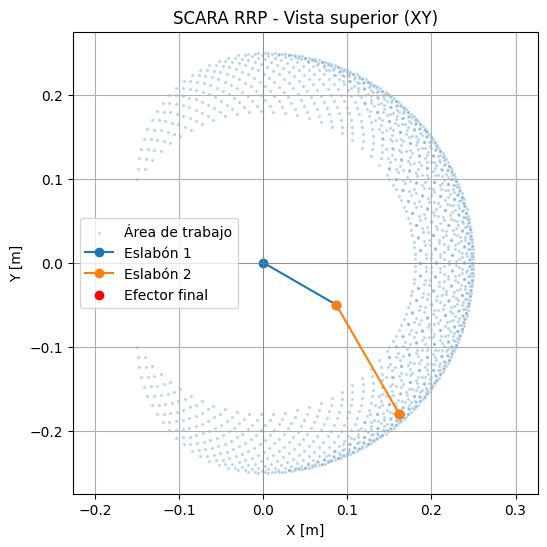

In [7]:
# Visualización del SCARA en el plano XY y área de trabajo aproximada

# Posición de la junta intermedia (final del primer eslabón)
x1 = L1 * np.cos(q1_rad)
y1 = L1 * np.sin(q1_rad)

# Efector final según modelo plano
x_ef, y_ef, _ = fk_scara_planar(q1_rad, q2_rad, d3_m)

plt.figure(figsize=(6, 6))
plt.title("SCARA RRP - Vista superior (XY)")
plt.xlabel("X [m]")
plt.ylabel("Y [m]")

# Área de trabajo aproximada
q1_vals = np.deg2rad(np.linspace(-90, 90, 40))
q2_vals = np.deg2rad(np.linspace(-90, 90, 40))
ws_x, ws_y = [], []

for q1_tmp in q1_vals:
    for q2_tmp in q2_vals:
        xt, yt, _ = fk_scara_planar(q1_tmp, q2_tmp, 0.0)
        ws_x.append(xt)
        ws_y.append(yt)

plt.scatter(ws_x, ws_y, s=2, alpha=0.2, label="Área de trabajo")

# Dibujo del robot en la posición actual
plt.plot([0, x1], [0, y1], marker='o', label="Eslabón 1")
plt.plot([x1, x_ef], [y1, y_ef], marker='o', label="Eslabón 2")
plt.scatter([x_ef], [y_ef], c='red', label="Efector final")

plt.axhline(0, linewidth=0.5, color='gray')
plt.axvline(0, linewidth=0.5, color='gray')
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.show()


In [14]:
# Enviar los valores actuales (q1_rad, q2_rad, d3_m) al Arduino

if ser is None:
    print("No hay puerto serie abierto. No se enviarán datos.")
else:
    line = f"{q1_rad:.4f},{q2_rad:.4f},{d3_m:.4f}\n"
    ser.write(line.encode('ascii'))
    print("Valores enviados al Arduino:")
    print(line.strip())


Valores enviados al Arduino:
-0.5236,-0.5236,0.0200


## 4. Pruebas experimentales (tres configuraciones diferentes)

En esta sección se realizan al menos tres pruebas con diferentes combinaciones 
de `(q1, q2, d3)` dentro de los límites físicos del robot.

Para cada caso se registra:

- Variables de entrada: `q1`, `q2`, `d3`.
- Posición final calculada: `x`, `y`, `z`.
- Observación cualitativa del movimiento del robot.

Al final se construye una tabla con `pandas` que se integra al reporte.


In [10]:

# ==========================================
# 4. PRUEBAS EXPERIMENTALES (3 CASOS)
# ==========================================

pruebas = []

num_pruebas = 3  # puedes aumentar si quieres

for i in range(1, num_pruebas + 1):
    print(f"\n=== Prueba {i} ===")
    q1_deg_i = float(input("q1 [°]: "))
    q2_deg_i = float(input("q2 [°]: "))
    d3_mm_i  = float(input("d3 [mm]: "))

    q1_rad_i = np.deg2rad(q1_deg_i)
    q2_rad_i = np.deg2rad(q2_deg_i)
    d3_m_i   = d3_mm_i / 1000.0

    res_i = fk_scara(q1_rad_i, q2_rad_i, d3_m_i)
    x_i, y_i, z_i = res_i["x"], res_i["y"], res_i["z"]

    print(f"Posición (m): x={x_i:.4f}, y={y_i:.4f}, z={z_i:.4f}")
    obs_i = input("Observación cualitativa del movimiento del robot: ")

    pruebas.append({
        "Prueba": i,
        "q1_deg": q1_deg_i,
        "q2_deg": q2_deg_i,
        "d3_mm": d3_mm_i,
        "x_m": x_i,
        "y_m": y_i,
        "z_m": z_i,
        "Observacion": obs_i
    })

df_pruebas = pd.DataFrame(pruebas)
df_pruebas



=== Prueba 1 ===


q1 [°]:  -30
q2 [°]:  -30
d3 [mm]:  20


Posición (m): x=0.1616, y=-0.1799, z=-0.0080


Observación cualitativa del movimiento del robot:  Brazo a la izquierda (vista de frente) con z ligeramente desplazado



=== Prueba 2 ===


q1 [°]:  30
q2 [°]:  30
d3 [mm]:  0


Posición (m): x=0.1616, y=0.1799, z=0.0120


Observación cualitativa del movimiento del robot:  Brazo a la derecha (vista de frente) con z al origen



=== Prueba 3 ===


q1 [°]:  0
q2 [°]:  0
d3 [mm]:  60


Posición (m): x=0.2500, y=-0.0000, z=-0.0480


Observación cualitativa del movimiento del robot:  Brazo alineado al centro (vista de frente) con z en su máximo desplazamiento


,Prueba,q1_deg,q2_deg,d3_mm,x_m,y_m,z_m,Observacion
0,1,-30.0,-30.0,20.0,0.161603,-1.799038e-01,-0.008,Brazo a la izquierda (vista de frente) con z l...
1,2,30.0,30.0,0.0,0.161603,1.799038e-01,0.012,Brazo a la derecha (vista de frente) con z al ...
2,3,0.0,0.0,60.0,0.250000,-7.347881e-18,-0.048,Brazo alineado al centro (vista de frente) con...


## 5. Generación del GIF de evidencia

En esta sección se genera un GIF que muestra:

- La ejecución del Notebook (cálculo de la cinemática directa).
- La representación gráfica del robot SCARA y el cambio de posición
  entre las diferentes pruebas.


In [11]:
import imageio
from pathlib import Path

# Carpeta de salida
media_dir = Path("media")
media_dir.mkdir(exist_ok=True)

gif_path = media_dir / "scara_pruebas.gif"

frames = []

# --- 1) Área de trabajo (para fondo del XY) ---
q1_ws = np.deg2rad(np.linspace(-90, 90, 40))
q2_ws = np.deg2rad(np.linspace(-90, 90, 40))

ws_x = []
ws_y = []

for q1w in q1_ws:
    for q2w in q2_ws:
        xw, yw, _ = fk_scara_planar(q1w, q2w, 0.0)
        ws_x.append(xw)
        ws_y.append(yw)

ws_x = np.array(ws_x)
ws_y = np.array(ws_y)

# --- 2) Construimos la trayectoria a partir de las pruebas ----
if len(pruebas) == 0:
    raise ValueError("La lista 'pruebas' está vacía. Ejecuta primero la celda de las pruebas.")

# Comenzamos desde una pose neutra (puedes cambiarla si quieres)
q1_prev = 0.0           # rad
q2_prev = 0.0           # rad
d3_prev = 0.0           # m

# Cuántos pasos intermedios entre una prueba y la siguiente
pasos_por_prueba = 12

for p in pruebas:
    q1_target = np.deg2rad(p["q1_deg"])
    q2_target = np.deg2rad(p["q2_deg"])
    d3_target = p["d3_mm"] / 1000.0

    # Interpolamos desde la pose anterior hasta la nueva
    for alpha in np.linspace(0, 1, pasos_por_prueba):
        q1 = q1_prev + (q1_target - q1_prev) * alpha
        q2 = q2_prev + (q2_target - q2_prev) * alpha
        d3 = d3_prev + (d3_target - d3_prev) * alpha

        # Cinemática para este frame
        x_xy, y_xy, _ = fk_scara_planar(q1, q2, d3)
        res_fk = fk_scara(q1, q2, d3)
        z_fk   = res_fk["z"]

        # --- Figura con 2 vistas: XY y Z ---
        fig = plt.figure(figsize=(8, 4))
        ax_xy = fig.add_subplot(1, 2, 1)
        ax_z  = fig.add_subplot(1, 2, 2)

        fig.patch.set_facecolor("#02010F")
        ax_xy.set_facecolor("#02010F")
        ax_z.set_facecolor("#02010F")

        # ----- Vista XY -----
        ax_xy.scatter(ws_x, ws_y, s=3, alpha=0.18, color="#1D4ED8", label="Área de trabajo")

        # Eslabones
        x1 = L1 * np.cos(q1)
        y1 = L1 * np.sin(q1)

        ax_xy.plot([0, x1], [0, y1], "-o", color="#FACC15", label="Eslabón 1")
        ax_xy.plot([x1, x_xy], [y1, y_xy], "-o", color="#FB923C", label="Eslabón 2")
        ax_xy.scatter([x_xy], [y_xy], c="red", s=35, label="Efector")

        ax_xy.axhline(0, linewidth=0.5, color="#4B5563")
        ax_xy.axvline(0, linewidth=0.5, color="#4B5563")
        ax_xy.set_aspect("equal", "box")
        ax_xy.set_xlabel("X [m]", color="#9CA3AF")
        ax_xy.set_ylabel("Y [m]", color="#9CA3AF")
        ax_xy.tick_params(colors="#9CA3AF")
        ax_xy.set_title("Vista superior XY", color="#F9FAFB", fontsize=11)

        r = L1 + L2 + 0.02
        ax_xy.set_xlim(-r, r)
        ax_xy.set_ylim(-r, r)

        ax_xy.legend(
            loc="upper right",
            fontsize=7,
            facecolor="#02010F",
            edgecolor="#1F2933"
        )

        # ----- Vista eje Z -----
        z_min_plot = D0 - 0.06 - 0.005
        z_max_plot = D0 + 0.005

        ax_z.set_xlim(0, 1)
        ax_z.set_ylim(z_min_plot, z_max_plot)

        ax_z.plot(
            [0.5, 0.5],
            [z_min_plot, z_max_plot],
            linestyle="--",
            color="#4B5563",
            linewidth=2,
        )

        ax_z.scatter([0.5], [z_fk], color="#22C55E", s=80, zorder=5)
        ax_z.text(
            0.52,
            z_fk,
            f"{z_fk:.3f} m",
            color="#F9FAFB",
            fontsize=9,
            va="center",
        )

        ax_z.set_xticks([])
        ax_z.set_ylabel("Z [m]", color="#9CA3AF")
        ax_z.tick_params(colors="#9CA3AF")
        ax_z.set_title("Eje Z – Altura del efector", color="#F9FAFB", fontsize=11)

        # ----- Texto con datos de la prueba objetivo -----
        num_prueba = p.get("Prueba", "?")
        info = (
            f"Prueba {num_prueba}  |  "
            f"q1 = {p['q1_deg']:.1f}°,  q2 = {p['q2_deg']:.1f}°,  d3 = {p['d3_mm']:.1f} mm\n"
            f"x = {p['x_m']:.3f} m,  y = {p['y_m']:.3f} m,  z = {p['z_m']:.3f} m"
        )
        fig.text(0.02, 0.96, info, color="#F9FAFB", fontsize=9, va="top")

        # ---------- Convertir figura a frame (AQUÍ ESTABA EL ERROR) ----------
        fig.canvas.draw()
        w, h = fig.canvas.get_width_height()
        # buffer_rgba() -> RGBA; lo convertimos a array y quitamos el canal alfa
        buf = np.frombuffer(fig.canvas.buffer_rgba(), dtype=np.uint8)
        frame = buf.reshape(h, w, 4)[..., :3]
        frames.append(frame)

        plt.close(fig)

    # La siguiente interpolación parte desde la pose objetivo actual
    q1_prev = q1_target
    q2_prev = q2_target
    d3_prev = d3_target

# --- 3) Guardar GIF ---
imageio.mimsave(gif_path, frames, fps=6)
gif_path


WindowsPath('media/scara_pruebas.gif')

## 6. Cierre

En este Notebook se implementó la cinemática directa del robot SCARA RRP, 
se verificaron los límites articulares, se enviaron configuraciones al 
Arduino y se documentaron pruebas experimentales con su respectiva evidencia en GIF.

Este archivo se incluirá en el repositorio de GitHub junto con:

- Código de Arduino (`arduino_scara.ino`).
- Carpeta `media/` con el GIF generado.
- Archivo `README.md` con instrucciones de uso.


In [15]:
# Cerrar el puerto serie al terminar el uso del Notebook

if 'ser' in globals() and ser is not None and ser.is_open:
    ser.close()
    print("Puerto serie cerrado correctamente.")
else:
    print("No había puerto serie abierto o ya estaba cerrado.")


Puerto serie cerrado correctamente.
